In [2]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import pandas as pd

### Vad som skulle kunna tas med 
- Andel tävlande i utrustad/bp/SL tävlingar över tid. Borde se att KL SL blir mer och mer populärt.
- Andel män/kvinnor som tävlar över tid. Borde se att  det blir mer jämlikt.
- Medelresultatet i SL tävlingar för U/J/S i samtliga viktklasser över tid. Typ boxplots.
- Fördelningen på 1 tävling (hur ser fördelningen av lyftare ut, nu och då), ta typ stora tävlingar som JSM/SM.
- Stjärnskott - hur ofta uppkommer de?
- Hur många tävlingar görs i medel av varje lyftare (fördelning)

In [75]:
def start_browser(URL):
    options = Options()
    options.add_argument("start-maximized")
    options.add_argument("disable-infobars")
    options.add_argument("--disable-extensions")
    options.add_argument('--headless')
    browser = webdriver.Chrome(options=options)
    browser.get(URL)
    return browser

URL = "https://online.styrkelyft.se/web/oldContest.aspx"

def get_comp_list(browser):
    html = browser.page_source
    soup = BeautifulSoup(html, features="html.parser")
    table = soup.find('table', attrs={'id':"ContentPlaceHolder2_usersGridView"})
    table_body = table.find('tbody')
    rows = table_body.find_all('tr', {'style':'color:#333333;background-color:#E7E7E7;'})
    comp_dict ={'href': [],'comp':[], 'date':[],'type':[]}
    for row in rows:
        cols = row.find('td')
        data = row.find_all('td')
        data = [ele.text.strip() for ele in data]
        comp_dict['comp'].append(data[0])
        comp_dict['date'].append(data[1])
        comp_dict['type'].append(data[2])
        c = cols.find_all('a', href=True)
        comp_dict['href'].append(c[0]['href'])
    return comp_dict

def go_to_next_page_x(browser, page_count):
    browser.find_element_by_xpath(f'//*[@id="ContentPlaceHolder2_usersGridView"]/tbody/tr[22]/td/table/tbody/tr/td[{page_count}]').click()
    
def go_to_next_page(browser, page_count):
    browser.find_element_by_xpath(f'//a[contains(@href,"Page${page_count}")]').click()
    
def iterate_through_pages(URL):
    browser = start_browser(URL)
    page_count = 1
    dfs = []
    while page_count < 41:
        print(f'Page: {page_count}')
        comp_dict = get_comp_list(browser)
        comp_df = pd.DataFrame(comp_dict, columns = ['href','comp','date','type'])
        dfs.append(comp_df)
        go_to_next_page(browser, page_count)
        page_count += 1
    return dfs
    
    

compdfs = iterate_through_pages(URL)
compdf = pd.concat(compdfs)
compdf

Page: 1
Page: 2
Page: 3
Page: 4
Page: 5
Page: 6
Page: 7
Page: 8
Page: 9
Page: 10
Page: 11
Page: 12
Page: 13
Page: 14
Page: 15
Page: 16
Page: 17
Page: 18
Page: 19
Page: 20
Page: 21
Page: 22
Page: 23
Page: 24
Page: 25
Page: 26
Page: 27
Page: 28
Page: 29
Page: 30
Page: 31
Page: 32
Page: 33
Page: 34
Page: 35
Page: 36
Page: 37
Page: 38
Page: 39
Page: 40


,href,comp,date,type
0,contestResult.aspx?contestId=3573,U/J SM Styrkelyft klassisk,2022-05-05,Klassisk Styrkelyft
1,contestResult.aspx?contestId=3579,EM utrustad Styrkelyft,2022-05-03,Styrkelyft
2,contestResult.aspx?contestId=3559,Norrländska mästerskapen Styrkelyft utrustat,2022-04-08,Styrkelyft
3,contestResult.aspx?contestId=3561,Norrländska mästerskapen Bänkpress utrustat,2022-04-08,Bänkpress
4,contestResult.aspx?contestId=3548,SM Styrkelyft klassisk,2022-03-24,Klassisk Styrkelyft
...,...,...,...,...
5,contestResult.aspx?contestId=239,NT Toppengalan,2008-07-05,Bänkpress
6,contestResult.aspx?contestId=237,NT-Westbo AK SL,2008-06-28,Styrkelyft
7,contestResult.aspx?contestId=228,VM BP,2008-06-25,Bänkpress
8,contestResult.aspx?contestId=236,NT Skellefteå,2008-06-14,Styrkelyft


In [76]:
    
def go_to_comp(href, datum):
    BASE_URL = "https://online.styrkelyft.se/web/"
    comp_browser = start_browser(f"{BASE_URL}{href}")
    return get_comp_data(comp_browser,datum)
    


def categorize_data(strip):
    if strip[0].startswith('Herr') or  strip[0].startswith('Dam'):
        return 'kategori'
    elif strip[0].startswith('Viktklass'):
        return 'viktklass'
    elif strip[0].startswith('Plac'):
        return 'header'
    else:
        return 'resultat'

def get_comp_data(browser, datum):
    try: 
        html = browser.page_source
        soup = BeautifulSoup(html, features="html.parser")
        comp = soup.find('span', attrs={'id':"ContentPlaceHolder2_Header"})
        print(datum, comp.text.strip())
        table = soup.find('table', attrs={'id':"ContentPlaceHolder2_contestTable"})
        table_body = table.find('tbody')
        rows = table_body.find_all('tr')
        score_dict = {'datum': [], 'tävling': [], 'kategori': [], 'viktklass':[], 'data':[]}
        category = ""
        weight_class = ""
        for row in rows:
            cols = row.find_all('td')
            strip =  [ele.text.strip() for ele in cols]
            cat = categorize_data(strip)
            if cat != 'header':
                if cat == "kategori":
                    category = strip
                elif cat == "viktklass":
                    weight_class = strip
                else:
                    score_dict['datum'] += [datum]
                    score_dict['kategori'] += category
                    score_dict['viktklass'] += weight_class
                    score_dict['tävling'] += comp
                    score_dict['data'].append(strip)
        df = pd.DataFrame(score_dict)
        return df
    
    except AttributeError:
        print('No data')
        df = pd.DataFrame()
    return df
    
compdf = pd.concat(compdfs)
dfs = []
for href, date in zip(compdf['href'],compdf['date']):
    df = go_to_comp(href, date)
    dfs.append(df)


tot = pd.concat(dfs)
tot

2022-05-05 U/J SM Styrkelyft klassisk
2022-05-03 EM utrustad Styrkelyft
2022-04-08 Norrländska mästerskapen Styrkelyft utrustat
2022-04-08 Norrländska mästerskapen Bänkpress utrustat
2022-03-24 SM Styrkelyft klassisk
2022-03-24 Universitets EC Styrkelyft klassisk
2021-12-04 Special Olympic Västerås
2021-11-18 SM Junior & Ungdom Styrkelyft klassisk
2021-11-08 VM Styrkelyft utrustat
2021-11-06 NM Junior Styrkelyft utrustat
2018-04-27 u/j/v-SM Klassisk bänkpress 2018
2018-03-23 SM-veckan Skellefteå (bänkpress)
2018-03-04 Arnold Sports Festival - Utrustad BP
2018-03-03 Arnold Sports Festival - Utrustad SL
2018-02-24 DM klassisk bänkpress (SÖSF)
No data
2017-12-10 u/j/v-SM Bänkpress 2017
2017-12-01 European Classic Cup
2017-11-18 DM klassisk styrkelyft SNSF
2017-11-18 DM klassisk styrkelyft (MNSF)
2017-11-18 DM bänkpress (VSSF)
2021-11-06 NM Junior Bänkpress utrustat
2021-10-23 DM Styrkelyft utrustat SÖSF
No data
2021-10-23 DM Bänkpress klassisk SÖSF
2021-10-23 DM Styrkelyft klassisk NNSF
2

,datum,tävling,kategori,viktklass,data
0,2022-05-05,U/J SM Styrkelyft klassisk,Herr Ungdom,"Viktklass 59,00","[1, Kevin Kalhour, Become an Athlete Styrkesäl..."
1,2022-05-05,U/J SM Styrkelyft klassisk,Herr Ungdom,"Viktklass 59,00","[2, Lukas Broström, Täby AK, 58,50, 120,00, 6..."
2,2022-05-05,U/J SM Styrkelyft klassisk,Herr Ungdom,"Viktklass 66,00","[1, Anders Nguyen, Göteborgs SK, 65,05, 200,00..."
3,2022-05-05,U/J SM Styrkelyft klassisk,Herr Ungdom,"Viktklass 66,00","[2, Valdemar Kesa, Stockholms AK, 65,85, 175,0..."
4,2022-05-05,U/J SM Styrkelyft klassisk,Herr Ungdom,"Viktklass 66,00","[3, Benjamin Olofsson, Borlänge AK, 65,75, 125..."
...,...,...,...,...,...
5,2008-05-06,EM SL-08,Dam Senior,"Viktklass 52,00","[-, Carola Lindström, Borås AK, 51,30, 0,00, 0..."
6,2008-05-06,EM SL-08,Dam Senior,"Viktklass 56,00","[3, Maria Eriksson, Malmö Lyftarklubb, 55,80, ..."
7,2008-05-06,EM SL-08,Dam Senior,"Viktklass 56,00","[4, Marie Eriksson, Borås AK, 54,70, 152,50, 7..."
8,2008-05-06,EM SL-08,Dam Senior,"Viktklass 60,00","[6, Helene Johage, Täby AK, 59,90, 160,00, 90,..."


In [ ]:
def clean(d):
    d = d.replace("[", "")
    d = d.replace("\'", "")
    d = d.replace("]", "")
    return d

df['data'] = df.apply(lambda x: clean(x['data']), axis=1)
df['len'] = df.apply(lambda x: len(x['data'].split(', ')), axis=1)
df_sl = df[df['len'] == 10]
df_b = df[df['len'] == 7]

df_sl[['placering', 'namn', 'förening', 'kroppsvikt', 'böj', 'bänk', 'mark','total', 'poäng', 'diskvalificerad']] = df_sl['data'].str.split(', ', expand=True)
df_b[['placering', 'namn', 'förening', 'kroppsvikt', 'bänk', 'poäng', 'diskvalificerad']] = df_b['data'].str.split(', ', expand=True)
tot = pd.concat([df_sl,df_b])
tot['viktklass'] = tot['viktklass'].apply(lambda x: x.split(' ')[-1])

df_clean = tot[['datum','tävling','kategori','viktklass','placering','namn','förening','kroppsvikt','böj','bänk','mark','total','poäng','diskvalificerad']]
df_clean = df_clean.apply(lambda x: x.str.replace(',','.'))
df_clean[['kroppsvikt','böj','bänk','mark','total','poäng']] = df_clean[['kroppsvikt','böj','bänk','mark','total','poäng']].astype(float)
df_clean['kön'] = df_clean['kategori'].apply(lambda x: x.split(' ')[0])
df_clean['datum'] = pd.to_datetime(df_clean['datum'])



In [5]:
df = pd.read_csv('complete.csv')
df = df[['datum','tävling','kategori','viktklass','placering','namn','förening','kroppsvikt','böj','bänk','mark','total','poäng','diskvalificerad','kön','tävlingstyp','count']]
df

,datum,tävling,kategori,viktklass,placering,namn,förening,kroppsvikt,böj,bänk,mark,total,poäng,diskvalificerad,kön,tävlingstyp,count
0,2022-05-05,U/J SM Styrkelyft klassisk,Herr Ungdom,59.00,1,Kevin Kalhour,Become an Athlete Styrkesällskap,57.90,132.5,108.0,165.0,405.5,357.49,NaN,Herr,klassisk sl,1
1,2022-05-05,U/J SM Styrkelyft klassisk,Herr Ungdom,59.00,2,Lukas Broström,Täby AK,58.50,120.0,67.5,135.0,322.5,281.57,NaN,Herr,klassisk sl,1
2,2022-05-05,U/J SM Styrkelyft klassisk,Herr Ungdom,66.00,1,Anders Nguyen,Göteborgs SK,65.05,200.0,110.0,222.5,532.5,423.17,NaN,Herr,klassisk sl,1
3,2022-05-05,U/J SM Styrkelyft klassisk,Herr Ungdom,66.00,2,Valdemar Kesa,Stockholms AK,65.85,175.0,112.5,172.5,460.0,361.87,NaN,Herr,klassisk sl,1
4,2022-05-05,U/J SM Styrkelyft klassisk,Herr Ungdom,66.00,3,Benjamin Olofsson,Borlänge AK,65.75,125.0,125.0,197.5,447.5,352.48,NaN,Herr,klassisk sl,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10415,2008-06-25,VM BP,Herr Senior,125.00,-,Fredrik Svensson,Sundsvalls AK,123.50,NaN,0.0,NaN,NaN,0.00,Diskad,Herr,utrustad bp,1
10416,2008-06-25,VM BP,Herr Senior,+125,2,Johnny Wahlqvist,Lunds TK,169.40,NaN,325.0,NaN,NaN,176.62,NaN,Herr,utrustad bp,1
10417,2008-06-25,VM BP,Dam Senior,67.50,-,Anna Maria Nöglegaard,Stockholmspolisens IF Kraftsportförening,63.60,NaN,0.0,NaN,NaN,0.00,Diskad,Dam,utrustad bp,1
10418,2008-06-25,VM BP,Dam Senior,90.00,-,Maria Johansson,Skellefteå AK,87.80,NaN,0.0,NaN,NaN,0.00,Diskad,Dam,utrustad bp,1


## Funktioner

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

def klassisk_eller_utrustad(val):
    if 'lassis' in val:
        return "klassisk"
    else:
        return 'utrustad'
def sl_eller_bp(val):
    if 'yrkel' in val or 'SL' in val or 'sl' in val:
        return "sl"
    else:
        return 'bp'

df['klassisk/utrustad'] = df.apply(lambda x: klassisk_eller_utrustad(x['tävling']), axis=1)
df['sl/bp']  =df.apply(lambda x: sl_eller_bp(x['tävling']), axis=1)
df


,datum,tävling,kategori,viktklass,placering,namn,förening,kroppsvikt,böj,bänk,mark,total,poäng,diskvalificerad,kön,tävlingstyp,count,klassisk/utrustad,sl/bp
0,2022-05-05,U/J SM Styrkelyft klassisk,Herr Ungdom,59.00,1,Kevin Kalhour,Become an Athlete Styrkesällskap,57.90,132.5,108.0,165.0,405.5,357.49,NaN,Herr,klassisk sl,1,klassisk,sl
1,2022-05-05,U/J SM Styrkelyft klassisk,Herr Ungdom,59.00,2,Lukas Broström,Täby AK,58.50,120.0,67.5,135.0,322.5,281.57,NaN,Herr,klassisk sl,1,klassisk,sl
2,2022-05-05,U/J SM Styrkelyft klassisk,Herr Ungdom,66.00,1,Anders Nguyen,Göteborgs SK,65.05,200.0,110.0,222.5,532.5,423.17,NaN,Herr,klassisk sl,1,klassisk,sl
3,2022-05-05,U/J SM Styrkelyft klassisk,Herr Ungdom,66.00,2,Valdemar Kesa,Stockholms AK,65.85,175.0,112.5,172.5,460.0,361.87,NaN,Herr,klassisk sl,1,klassisk,sl
4,2022-05-05,U/J SM Styrkelyft klassisk,Herr Ungdom,66.00,3,Benjamin Olofsson,Borlänge AK,65.75,125.0,125.0,197.5,447.5,352.48,NaN,Herr,klassisk sl,1,klassisk,sl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10415,2008-06-25,VM BP,Herr Senior,125.00,-,Fredrik Svensson,Sundsvalls AK,123.50,NaN,0.0,NaN,NaN,0.00,Diskad,Herr,utrustad sl,1,utrustad,bp
10416,2008-06-25,VM BP,Herr Senior,+125,2,Johnny Wahlqvist,Lunds TK,169.40,NaN,325.0,NaN,NaN,176.62,NaN,Herr,utrustad sl,1,utrustad,bp
10417,2008-06-25,VM BP,Dam Senior,67.50,-,Anna Maria Nöglegaard,Stockholmspolisens IF Kraftsportförening,63.60,NaN,0.0,NaN,NaN,0.00,Diskad,Dam,utrustad sl,1,utrustad,bp
10418,2008-06-25,VM BP,Dam Senior,90.00,-,Maria Johansson,Skellefteå AK,87.80,NaN,0.0,NaN,NaN,0.00,Diskad,Dam,utrustad sl,1,utrustad,bp


-----

## En analys av svenskt styrkelyft
Sverige har en lång historia av duktiga styrkelyftare och bänkpressare, och idag är Sverige en av de ledande nationerna i de båda sporterna. Vi ser en ökat intresse av kraftsporter, vilket till stor del kan attribueras till sociala medier och starka personligheter inom sporterna. Det ökade intresset innebär fler tävlande, och speciellt fler duktiga tävlande. Ett rekord för 20 år sedan är en ingångsvikt på världscenen idag, och vi ser även att kvalitén på lyftare har ökat markant på en nationell nivå. Detta återspeglas särskilt i ökningen av kvalgränser och standard. Gemene man kan även lägga märke till andra tendenser inom sporten - ett skiftande från utrustad till klassisk lyftning, en föryngring av tävlande, och en mer jämnlik sport. Jag har använt mig av Svenska Styrkelyfts Förbundents databas för analysera dessa trender, och se på den svenska utvecklingen i styrkelyft och bänkpress.

In [41]:
antal_unika_tävlande = len(df['namn'].unique())
print('Tävlande: ', antal_unika_tävlande)
antal_tävlingar = len(df['tävling'].unique())
print('Tävlingar: ', antal_tävlingar)
kön = df.groupby('kön').sum()
print(kön['count'])
unika_kön = df.groupby(['namn','kön']).sum()
unika_kön['count'] = 1
unika_kön = unika_kön.groupby('kön').sum()
print(unika_kön['count'])
kategori_df = df.groupby(['klassisk/utrustad','sl/bp']).sum()
print(kategori_df['count'])

Tävlande:  3135
Tävlingar:  338
kön
Dam     2725
Herr    7695
Name: count, dtype: int64
kön
Dam      848
Herr    2292
Name: count, dtype: int64
klassisk/utrustad  sl/bp
klassisk           bp       1868
                   sl       3526
utrustad           bp       2913
                   sl       2113
Name: count, dtype: int64


Totalt analyseras resultaten från 3135 unika tävlande, varav 2292 är herrar och 848 damer. Det finns 10420 datapunkter, varav 7695 herrar och 2725 är damer, från 338 tävlingar mellan 2008/05/06 och 2022/05/05 (14 år). I klassisk styrkelyft/bänkpress finns 3526 respektive 1868 datapunkter. I utrustad styrkelyft/bänkpress finns 2113 respektive 2913 datapunkter. Majoriteten av alla lyftare (1317 st) har enbart utfört 1 tävling, och 613 st har utfört 2 tävlingar. Tomas Ring har utfört flest tävlingar (52 st).

namn
Tomas Ring          52
Jonas Telégin       37
Fredrik Svensson    33
Nicklas Karlsson    33
Lars Höglander      33
Name: count, dtype: int64
count
1    1317
2     613
3     353
4     225
5     141
Name: count_of_count, dtype: int64
Antal med 1 tävling:  1317


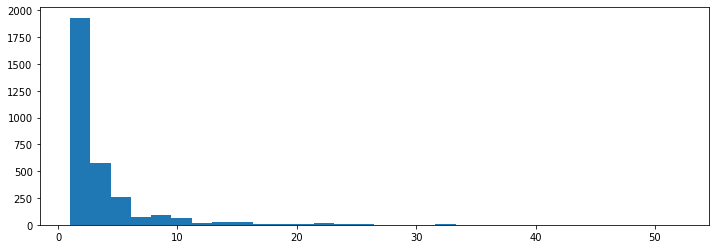

In [59]:
# fördelning av tävlingar per individ
tävlande = df.groupby('namn').sum()
tävlande.sort_values('count', ascending=False, inplace=True)
print(tävlande.head()['count'])
tävlande['count_of_count'] = 1
print(tävlande.groupby('count').sum()['count_of_count'].head())
print('Antal med 1 tävling: ', len(tävlande[tävlande['count'] == 1].index))
fig = plt.figure(figsize=(12,4))
plt.hist(tävlande['count'], bins=30)
plt.show()

Antal tävlande över tid ökade mellan 2009 - 2019 från ~750 till ~1200. Därefter slog pandemin, och antalet tävlande var låga 2020 och 2021 (<500). Antalet tävlande damer såg en särskild utveckling över tid.
Könsfördelning över tid
Utrustning / klassiskt över tid (för både SL och BP)

TypeError: set_ticks() got an unexpected keyword argument 'label'

<Figure size 864x288 with 0 Axes>

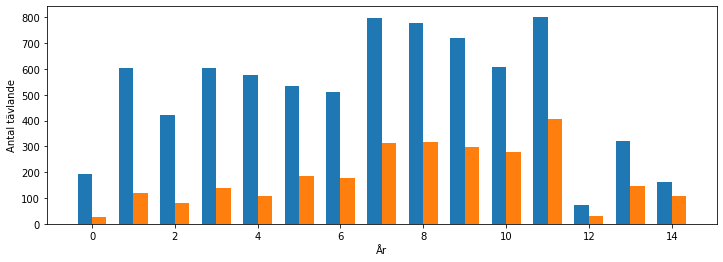

In [93]:
import numpy as np

kön_år = df.groupby(['år','kön']).sum()['count']
fig = plt.figure(figsize=(12,4))
kön_år = kön_år.unstack()
x = np.arange(len(kön_år.index))
width = 0.35


fig, ax = plt.subplots(figsize=(12,4))
rects1 = ax.bar(x - width/2, kön_år['Herr'], width, label='Herrar')
rects2 = ax.bar(x + width/2, kön_år['Dam'], width, label='Damer')
ax.set_ylabel('Antal tävlande')
ax.set_xlabel('År')
ax.set_title('Antal tävlande herrar och damer över tid')
ax.legend()